## This file follows the NYU 2019 approach to clean data and build the CF baseline model
https://github.com/jiangzl2016/yelp-rating-prediction/blob/master/1_baseline_and_collaborative_filtering.ipynb


In [218]:
import matplotlib.pyplot as plt
import pandas as pd
import tarfile
from tqdm import tqdm, tqdm_notebook, tnrange
import json
import numpy as np
import time
from copy import deepcopy



In [219]:
# Load three pre-processed datasets: reviews data, business data for selected candidate cities
sys_path = "/Users/sigao/Yelp/yelp_dataset/"
## The restaurants in the five candidate cities
restaurants_ = pd.read_csv(sys_path+ "business_data_subset.csv", index_col= None)
### reviews in the top 5 candidate cities
ratings_ = pd.read_csv(sys_path + "reviews_data_subset.csv")
### users that are found in the top cities' restaurant reviews
users_ = pd.read_csv(sys_path + "user_data_subset.csv")

## subset data and focus on one city


In [3]:
cities = restaurants_.city.unique()
cities

array(['Charlotte', 'Phoenix', 'Las Vegas', 'Toronto', 'Scottsdale'],
      dtype=object)

In [4]:
city = "Phoenix"

In [5]:
restaurants_ = restaurants_.loc[restaurants_.city == city]

In [6]:
## merge restaurants and ratings to get city info:
ratings_  = pd.merge(ratings_, restaurants_[['city','categories', 'business_id',"review_count"]], how = "inner", on ="business_id")
# df_toronto.to_csv("merged_Toronto_reviews.csv", index = None)
ratings_.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
0,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384
1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384
2,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384


In [7]:
ratings_.shape

(510982, 12)

In [8]:
rating_threshold = 5

In [9]:
user_counts = ratings_["user_id"].value_counts()
active_users= user_counts.loc[user_counts >= rating_threshold].index.tolist()
ratings_ = ratings_.loc[ratings_.user_id.isin(active_users)]
ratings_.shape

(262292, 12)

In [10]:
ratings_.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384
2,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384
3,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,0.0,0.0,0.0,"The craft beers are very good, but that's abou...",2016-03-30 22:28:36,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384
5,CfueO6B4_WauGRQ0cq9Whg,fhwZh6_7YxWeVEuskKMTcA,poSV39UqEg-gpESXafS9-g,5.0,2.0,0.0,0.0,Loved this place! \nI came for crab legs and w...,2016-05-07 01:19:53,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384
7,S8YMS-nYudRr-_NIT0CZqg,CyL4Nh9VHti5oIfcWevRIg,poSV39UqEg-gpESXafS9-g,5.0,0.0,1.0,2.0,I love sea food and I loved the Angry Crab Sha...,2016-02-11 23:00:41,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384


In [11]:
n_users = len(ratings_.user_id.unique())
n_restaurants = len(ratings_.business_id.unique())
n_ratings = len(ratings_)
print('Unique Users: {0}, unique restaurants: {1}, total reviews: {2}'.format(n_users, n_restaurants,n_ratings))

Unique Users: 20481, unique restaurants: 4164, total reviews: 262292


## Subsampling and Train-Test Split

In [12]:
# Sampling rate: 
# since we are building recommender systems city-by-city, no need to downsampling
SAMPLING_RATE = 1

In [13]:
# Downsample by users
user_id_unique = ratings_.user_id.unique()
user_id_sample = pd.DataFrame(user_id_unique, columns=['unique_user_id']) \
                    .sample(frac= SAMPLING_RATE, replace=False, random_state=1)

ratings_sample = ratings_.merge(user_id_sample, left_on='user_id', right_on='unique_user_id') \
                    .drop(['unique_user_id'], axis=1)
print(ratings_sample.head())
print(ratings_sample.shape)

                review_id                 user_id             business_id  \
0  aBWKb49Xfkv1946YN7_SIg  sSPbLBHcEMXaJfoO8zs1bA  poSV39UqEg-gpESXafS9-g   
1  qw-m8wZJZWxLGJjlOE0Tew  sSPbLBHcEMXaJfoO8zs1bA  3CBLxydJU6CFRMGhu9b-sw   
2  qhH0-khe2U1Vb88YGDxfuQ  sSPbLBHcEMXaJfoO8zs1bA  JRo3APL5f4-TEkuI-SoDcA   
3  EiFX8Z5o_zu8HAbP9mVGyw  sSPbLBHcEMXaJfoO8zs1bA  PmQqj0wAnraXPuPSZCzEZQ   
4  nFXB3me-0dpjwgzY_Hy5dg  sSPbLBHcEMXaJfoO8zs1bA  g3w01guDiTLszguA3vUrSg   

   stars  useful  funny  cool  \
0    5.0     0.0    0.0   0.0   
1    5.0     0.0    0.0   0.0   
2    2.0     1.0    0.0   0.0   
3    1.0     0.0    0.0   0.0   
4    5.0     0.0    0.0   0.0   

                                                text                 date  \
0  Amazing food, drinks, service!\n\nWe started w...  2016-01-17 05:33:14   
1  After being a relatively regular patron for th...  2017-04-14 02:58:03   
2  Solid 2-2.5 each time we have visited, includi...  2017-08-28 02:20:58   
3  After standing in line and 

In [14]:

# hold out last review
ratings_user_date = ratings_sample.loc[:, ['user_id', 'date']]
ratings_user_date.date = pd.to_datetime(ratings_user_date.date)
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_holdout_ = ratings_sample[index_holdout]
ratings_traincv_ = ratings_sample[~index_holdout]

ratings_user_date = ratings_traincv_.loc[:, ['user_id', 'date']]
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_cv_ = ratings_traincv_[index_holdout]
ratings_train_ = ratings_traincv_[~index_holdout]

# remove the user that has fake reviews 

cv_users_del = set(ratings_cv_.user_id) - set(ratings_train_.user_id)
holdout_users_del = set(ratings_holdout_.user_id) - set(ratings_train_.user_id)
ratings_cv_ = ratings_cv_[~ratings_cv_.user_id.isin(cv_users_del)]
ratings_holdout_ = ratings_holdout_[~ratings_holdout_.user_id.isin(holdout_users_del)]

# ratings_cv_ = ratings_cv_[~ratings_cv_.user_id.isin(['HiT9sg9pvDiEVMFHJYihXg'])]
# ratings_holdout_ = ratings_holdout_[~ratings_holdout_.user_id.isin(['HiT9sg9pvDiEVMFHJYihXg'])]

print('There are {0} rows, {1} columns in training set.'.format(ratings_train_.shape[0], ratings_train_.shape[1]))
print('There are {0} rows, {1} columns in training set.'.format(ratings_cv_.shape[0], ratings_cv_.shape[1]))
print('There are {0} rows, {1} columns in holdout set.'.format(ratings_holdout_.shape[0], ratings_holdout_.shape[1]))

There are 221326 rows, 12 columns in training set.
There are 20481 rows, 12 columns in training set.
There are 20480 rows, 12 columns in holdout set.


In [15]:
# check if we have a enough user sample size (> 20000)
number_of_unique_users = len(ratings_train_.user_id.unique())
print(number_of_unique_users)

20480


### Further cleaning

In [16]:
def process(df):
    df['date']  = pd.to_datetime(df['date'])
    df['week_day'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour
    df = df.merge(users_, on = 'user_id', how = "inner")
#     df = df.merge(restaurants_, on = 'business_id')
    rename_dict = {'business_longitude': 'longitude', 'business_latitude': 'latitude',
                  'business_state':'state','business_city':'city', 'business_address': 'address'}
    df = df.rename(columns = rename_dict)
    return df

ratings_train = process(ratings_train_.copy())
ratings_test = process(ratings_holdout_.copy())
ratings_val = process(ratings_cv_.copy())

In [17]:
ratings_train.shape

(221326, 15)

In [18]:
ratings_train.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count,week_day,month,hour
0,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384,6,1,5
1,qw-m8wZJZWxLGJjlOE0Tew,sSPbLBHcEMXaJfoO8zs1bA,3CBLxydJU6CFRMGhu9b-sw,5.0,0.0,0.0,0.0,After being a relatively regular patron for th...,2017-04-14 02:58:03,Phoenix,"Sandwiches, Sports Bars, Bars, Barbeque, Arts ...",244,4,4,2
2,qhH0-khe2U1Vb88YGDxfuQ,sSPbLBHcEMXaJfoO8zs1bA,JRo3APL5f4-TEkuI-SoDcA,2.0,1.0,0.0,0.0,"Solid 2-2.5 each time we have visited, includi...",2017-08-28 02:20:58,Phoenix,"Bars, Sports Bars, Nightlife, Food, Restaurant...",198,0,8,2


In [19]:
ratings_train_final = ratings_train.append(ratings_val)
ratings_entire_df = ratings_train.append(ratings_val).append(ratings_test)

## Evaluation Metrics

In [20]:
ratings_test.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count,week_day,month,hour
4,nFXB3me-0dpjwgzY_Hy5dg,sSPbLBHcEMXaJfoO8zs1bA,g3w01guDiTLszguA3vUrSg,5.0,0.0,0.0,0.0,Excellent food and service all around. Among m...,2018-06-01 02:01:19,Phoenix,"Fondue, Hot Pot, Restaurants, Asian Fusion, Soup",245,4,6,2
30,Q7w9BHq63-RbtQQHILKHBA,D5ywfFmwtJxLReqAYlDDmw,S-mdSI4dMr-KeF28L5CMyA,5.0,0.0,0.0,0.0,Great new local place with great food and grea...,2017-09-20 18:05:44,Phoenix,"Pizza, Restaurants, Sandwiches, Italian, Chick...",130,2,9,18


In [21]:
unique_city_businesses = ratings_entire_df[['city','business_id']].drop_duplicates()
predict_df = ratings_test[['user_id','city']]
predict_df = predict_df.merge(unique_city_businesses, on = 'city')
# random initialization, needs to be substituted by actual predictions later.
predict_df['predictions'] = 2.5
predict_df.head()

,user_id,city,business_id,predictions
0,sSPbLBHcEMXaJfoO8zs1bA,Phoenix,poSV39UqEg-gpESXafS9-g,2.5
1,sSPbLBHcEMXaJfoO8zs1bA,Phoenix,3CBLxydJU6CFRMGhu9b-sw,2.5
2,sSPbLBHcEMXaJfoO8zs1bA,Phoenix,JRo3APL5f4-TEkuI-SoDcA,2.5
3,sSPbLBHcEMXaJfoO8zs1bA,Phoenix,PmQqj0wAnraXPuPSZCzEZQ,2.5
4,sSPbLBHcEMXaJfoO8zs1bA,Phoenix,-rCIoxp7pqN3xY7E3-v56Q,2.5


In [22]:
def get_all_metrics(predict_df, validation_subsample, ratings_train_final):
    top_10_recs = predict_df.groupby(['user_id','city'])['predictions'].nlargest(10).reset_index()
    out = validation_subsample
    cnt =0
    serendipity = 0
    
    
    for row in out.iterrows():
        row_values = row[1]
        top_10 = predict_df.loc[top_10_recs[top_10_recs['user_id'] == row_values['user_id']].level_2]['business_id']
        ###In top 10
        if row_values['business_id'] in top_10.values:
            cnt+=1
        user_history = ratings_train_final[ratings_train_final['user_id'] == row_values['user_id']]    
        been_there = [i for i in top_10.values if i in  user_history.business_id.values]
        serendipity += 1-len(been_there)/10
    
    top_10 = cnt/len(out)
    serendipity = serendipity/len(out)
    
    predict_df = predict_df.reset_index()
    
    analysis_df = predict_df.merge(top_10_recs, left_on = ['user_id','city','index'], \
                                   right_on = ['user_id','city','level_2'])
    
    coverage = (analysis_df.groupby('city')['business_id'].nunique()/50).values.mean()
    
    predict_df['rankings']=predict_df.groupby(['city','user_id'])['predictions']. \
                                                        rank(method="first",ascending = False)
    running_rankings =0
    for row in out.iterrows():
        row_values = row[1]
        user_recs = predict_df[(predict_df['user_id']==row_values['user_id'])
                            &(predict_df['city']==row_values['city'])
                             & (predict_df['business_id']==row_values['business_id'])
                              ]
        assert len(user_recs)==1
        running_rankings += user_recs['rankings'].sum()

    avg_rank = running_rankings / len(out)
    print(top_10, coverage, serendipity, avg_rank)
    
    return top_10, coverage, serendipity, avg_rank

## Modeling

## Baseline Model (Biased CF)

In [45]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 4.5 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-macosx_10_9_x86_64.whl size=779837 sha256=3b603cca54cf416d30fdd94ef038f78359e4ad09d81cc4fe90b726b8fdff1733
  Stored in directory: /Users/sigao/Library/Caches/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [24]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [26]:

# remove observations that may cause cold-start problem, which breaks the model.
ratings_test = ratings_test.loc[ratings_test.business_id.isin(ratings_train.business_id)]
ratings_val = ratings_val.loc[ratings_val.business_id.isin(ratings_train.business_id)]

In [27]:
trainset = ratings_train.loc[:,['user_id', 'business_id', 'stars']]
trainset.columns = ['userID', 'itemID','rating']
valset = ratings_val.loc[:, ['user_id', 'business_id', 'stars']]
valset.columns = ['userID', 'itemID','rating']
testset = ratings_test.loc[:, ['user_id', 'business_id', 'stars']]
testset.columns = ['userID', 'itemID','rating']

In [28]:
reader = Reader(rating_scale = (0.0, 5.0))
train_data = Dataset.load_from_df(trainset[['userID','itemID','rating']], reader)
val_data = Dataset.load_from_df(valset[['userID','itemID','rating']], reader)
test_data = Dataset.load_from_df(testset[['userID','itemID','rating']], reader)

train_sr = train_data.build_full_trainset()
val_sr_before = val_data.build_full_trainset()
val_sr = val_sr_before.build_testset()
test_sr_before = test_data.build_full_trainset()
test_sr = test_sr_before.build_testset()

#### Baseline biased ALS model:

In [29]:
bsl_options = {'method': 'als', 'n_epochs':3}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(train_sr)
predictions = bias_baseline.test(val_sr)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.2312


1.2311988173740696

In [28]:
# runtime on 20% data
start_time = time.time()
bias_baseline.fit(train_sr)
print("--- %s seconds ---" % (time.time() - start_time))

Estimating biases using als...
--- 0.17382192611694336 seconds ---


In [29]:

# Regression metrics 
bbase_p = bias_baseline.test(test_sr)
start_time = time.time()
bbase_20_df = pd.DataFrame(bbase_p, columns = ['userId','itemId','rating','pred_rating','x'])
accuracy.rmse(bbase_p)
print('R^2 for {}:'.format(city), r2_score(bbase_20_df.rating , bbase_20_df.pred_rating))
print('MAE for {}:'.format(city), mean_absolute_error(bbase_20_df.rating, bbase_20_df.pred_rating))
print("--- %s seconds ---" % (time.time() - start_time))

RMSE: 1.2755
R^2 for Phoenix: 0.18507267033119656
MAE for Phoenix: 1.0322239979308105
--- 0.06747627258300781 seconds ---


In [ ]:

# Ranking + coverage + novelty metrics
predict_df_baseline = predict_df.copy()
eval_set = Dataset.load_from_df(predict_df_baseline[['user_id','business_id','predictions']], reader)

bias_basline = BaselineOnly({'method': 'als', 'n_epochs':9})
eval_before = eval_set.build_full_trainset()
eval_sr = eval_before.build_testset()
bias_basline.fit(train_sr)
eval_pred = bias_basline.test(eval_sr)
#accuracy.rmse(predictions_50)
baseline_20 = pd.DataFrame(eval_pred, columns = ['userId','itemId','rating','pred_rating','x'])
predict_df_baseline['predictions'] = baseline_20.pred_rating

### Model-based Collaborative Filtering - SVD

In [30]:
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [31]:
RMSE_tune = {}
n_epochs = [ 20, 30,40]  # the number of iteration of the SGD procedure
lr_all = [0.001, 0.003, 0.005] # the learning rate for all parameters
reg_all =  [0.02, 0.05, 0.1, 0.4, 0.5] # the regularization term for all parameters

for n in n_epochs:
    for l in lr_all:
        for r in reg_all:
            print('Fitting n: {0}, l: {1}, r: {2}'.format(n, l, r))
            algo = SVD(n_epochs = n, lr_all = l, reg_all = r)
            algo.fit(train_sr)
            predictions = algo.test(val_sr)
            RMSE_tune[n,l,r] = accuracy.rmse(predictions)

Fitting n: 10, l: 0.001, r: 0.02
RMSE: 1.2917
Fitting n: 10, l: 0.001, r: 0.05
RMSE: 1.2926
Fitting n: 10, l: 0.001, r: 0.1
RMSE: 1.2929
Fitting n: 10, l: 0.001, r: 0.4
RMSE: 1.2953
Fitting n: 10, l: 0.001, r: 0.5
RMSE: 1.2970
Fitting n: 10, l: 0.003, r: 0.02
RMSE: 1.2560
Fitting n: 10, l: 0.003, r: 0.05
RMSE: 1.2553
Fitting n: 10, l: 0.003, r: 0.1
RMSE: 1.2543
Fitting n: 10, l: 0.003, r: 0.4
RMSE: 1.2612
Fitting n: 10, l: 0.003, r: 0.5
RMSE: 1.2631
Fitting n: 10, l: 0.005, r: 0.02
RMSE: 1.2397
Fitting n: 10, l: 0.005, r: 0.05
RMSE: 1.2389
Fitting n: 10, l: 0.005, r: 0.1
RMSE: 1.2382
Fitting n: 10, l: 0.005, r: 0.4
RMSE: 1.2449
Fitting n: 10, l: 0.005, r: 0.5
RMSE: 1.2478
Fitting n: 20, l: 0.001, r: 0.02
RMSE: 1.2696
Fitting n: 20, l: 0.001, r: 0.05
RMSE: 1.2688
Fitting n: 20, l: 0.001, r: 0.1
RMSE: 1.2694
Fitting n: 20, l: 0.001, r: 0.4
RMSE: 1.2733
Fitting n: 20, l: 0.001, r: 0.5
RMSE: 1.2760
Fitting n: 20, l: 0.003, r: 0.02
RMSE: 1.2342
Fitting n: 20, l: 0.003, r: 0.05
RMSE: 1.2332


In [33]:
import operator
min(RMSE_tune.items(), key=operator.itemgetter(1))[0]

(30, 0.005, 0.1)

In [34]:
# train and test on the optimal parameter
start_time = time.time()
algo_real = SVD(n_epochs = 30, lr_all = 0.005, reg_all = 0.1)
algo_real.fit(train_sr)
predictions = algo_real.test(test_sr)

In [35]:
accuracy.rmse(predictions)

RMSE: 1.2616


1.2616299048743893

In [36]:
accuracy.mae(predictions)

MAE:  1.0070


1.0069519782898286

In [37]:
r2_score([t[2] for t in predictions], [t[3] for t in predictions])

0.20274431505252244

In [ ]:
# To evaluate coverage and serendipity metrics, use evaluation set created earlier.
eval_20 = Dataset.load_from_df(predict_df[['user_id','business_id','predictions']], reader)
eval_before_20 = eval_20.build_full_trainset()
eval_sr_20 = eval_before_20.build_testset()
eval_pred_20 = algo_real.test(eval_sr_20)

baseline_20 = pd.DataFrame(eval_pred_20, columns = ['userId','itemId','rating','pred_rating','x'])
predict_df_20['predictions'] = baseline_20.pred_rating

In [ ]:
top_10, coverage, serendipity, avg_rank = get_all_metrics(predict_df_20, out, ratings_train_final)

### Collaborative Filtering - non-model based Cosine and SVD

In [57]:
import scipy.sparse as sparse
from scipy.sparse import csr_matrix

def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['userID'].unique())
    unique_bus = list(df['itemID'].unique())
    data = df['rating'].tolist()
    row = pd.Series(pd.Categorical(df["userID"],categories=unique_users)).cat.codes
    
#     df['user_id'].astype('category', categories=unique_users).cat.codes
#     col = df['business_id'].astype('category', categories=unique_bus).cat.codes
    col = pd.Series(pd.Categorical(df["itemID"], categories=unique_bus)).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix    

In [177]:
ratings_entire_df = trainset.append(valset).append(testset)
df_sparse = get_sparse_matrix(ratings_entire_df)
sparsity_clt = 1 - df_sparse.nnz/(df_sparse.shape[0]*df_sparse.shape[1])
sparsity_clt

0.9970575369383992

In [178]:
ratings_entire_df.drop("rating",axis = 1, inplace = True)

trainset_expand = pd.merge(trainset, ratings_entire_df, how = "outer", on = ["userID","itemID"]).fillna(0)
valset_expand = pd.merge(valset, ratings_entire_df, how = "outer", on = ["userID","itemID"]).fillna(0)
testset_expand = pd.merge(testset, ratings_entire_df, how = "outer", on = ["userID","itemID"]).fillna(0)


In [179]:
df_sparse_train = get_sparse_matrix(trainset_expand)
df_sparse_test = get_sparse_matrix(testset_expand)
df_sparse_val = get_sparse_matrix(valset_expand)
    
sparsity_clt = 1 - df_sparse_train.nnz/(df_sparse_train.shape[0]*df_sparse_train.shape[1])
sparsity_clt    
    

0.9970575369383992

In [180]:
print(df_sparse.nnz, df_sparse_train.nnz, df_sparse_val.nnz, df_sparse_test.nnz)

247133 247133 247133 247133


In [181]:
U_, S_, Vt_ = np.linalg.svd(df_sparse_train.todense())#k = min(sm_u_10_phx_res_train.shape)-1)
S_diag = np.diag(S_)

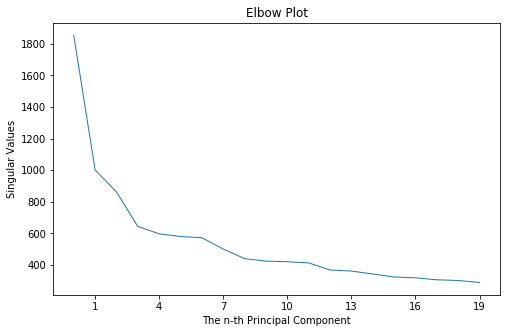

In [204]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_[:20], '-', linewidth=1)
plt.title('Elbow Plot')
# plt.xticks(np.arange(0, S_phx_res.shape[0]+1, 50), rotation='vertical')
plt.xlabel('The n-th Principal Component')
plt.xticks(range(1,21,3))
plt.ylabel('Singular Values')
plt.show()

In [184]:
def approx_err(k, A, U, S, Vt):
    rec_A = np.dot(U[:, :k], np.dot(S[:k,:k], Vt[:k, :]))
    idx = np.where(A>0);
    diff = A[idx] - rec_A[idx]
    return np.sqrt(np.linalg.norm(diff)**2/diff.shape[1])

Text(0.5, 1.0, 'Phoenix')

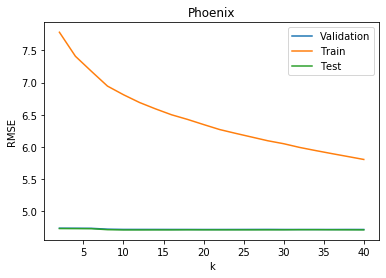

In [202]:
k = np.linspace(2,40,20, dtype = int)
errors_svd_val = {}
errors_svd_train = {}
errors_svd_test = {}
for i in k:
    errors_svd_val[i] =   approx_err(i, df_sparse_val.todense(),   U_, S_diag, Vt_)
    errors_svd_test[i] =   approx_err(i, df_sparse_test.todense(),   U_, S_diag, Vt_)
    errors_svd_train[i] = approx_err(i, df_sparse_train.todense(), U_, S_diag, Vt_)

plt.plot(k,list(errors_svd_val.values()), label = 'Validation')
plt.plot(k,list(errors_svd_train.values()), label = 'Train')
plt.plot(k,list(errors_svd_test.values()), label = 'Test')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend()
plt.title(city)

dict_values([4.727351105652918, 4.726312097933946, 4.725098033921179, 4.7098037216632465, 4.706068351890178, 4.706119849673813, 4.706651082718803, 4.706623136971479, 4.707781511826373, 4.707335971352676, 4.707171696600668, 4.707205272809604, 4.707130975433741, 4.707321968481861, 4.707537624938611, 4.709136619233915, 4.709163203023042, 4.708281161777875, 4.707539059668099, 4.706883559181007])

Best k
10
Best Test RMSE for SVD for Restaurants in Phoenix=  4.706068351890178


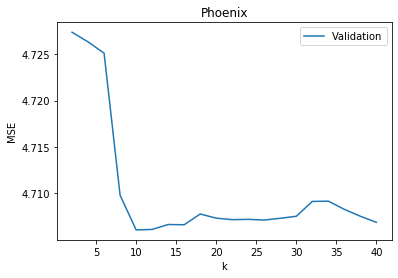

In [206]:
plt.plot(k,list(errors_svd_test.values()), label = 'Validation')
# plt.plot(k,list(errors_svd_train.values()), label = 'Train')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()
plt.title(city)
print("Best k")
k_opt = k[np.argmin(list(errors_svd_test.values()))]
print( k_opt)

Best_Test_RMSE_SVD = approx_err(k_opt, df_sparse_test.todense(), U_, S_diag, Vt_)
print('Best Test RMSE for SVD for Restaurants in {0}= '.format(city), Best_Test_RMSE_SVD)


### Non-Model based CF - SVD with bias correction


In [208]:
def find_global_user_res_bias(ratings_matrix):
    dense_matrix = ratings_matrix.todense()
    mask_matrix = (dense_matrix>0).astype(int)
    user_bias = np.sum(dense_matrix, axis = 1)/np.sum(mask_matrix, axis = 1)
    res_bias =  np.sum(dense_matrix, axis = 0)/np.sum(mask_matrix, axis = 0)
    user_bias = np.nan_to_num(user_bias)
    res_bias = np.nan_to_num(res_bias)
    user_bias = user_bias.reshape(-1,1)
    res_bias = res_bias.reshape(1,-1)
    ratings_matrix_wo_bias = dense_matrix - np.tile(user_bias, (1,dense_matrix.shape[1]))- np.tile(res_bias, (dense_matrix.shape[0], 1))
    return user_bias, res_bias, ratings_matrix_wo_bias

In [209]:
user_bias_ur, res_bias_ur, train_ur = find_global_user_res_bias(df_sparse_train)

In [210]:
U_bias_ur, S_bias_ur, Vt_bias_ur = np.linalg.svd(train_ur)
print("smallest singular value = ",min(S_bias_ur))
print("largest singular value = ",max(S_bias_ur))
S_bias_ur_diag = np.diag(S_bias_ur)

smallest singular value =  1.3159384193971196e-14
largest singular value =  90978.03207683914


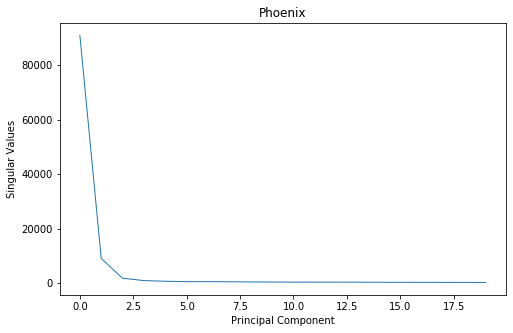

In [211]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_bias_ur[:20], '-', linewidth=1)
plt.title('Elbow Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.title(city)
plt.show()


In [ ]:
k_wo_bias_ur = np.linspace(2,40,20, dtype = int)
errors_svd_wo_bias_ur = {}
df_val_bias_ur = df_val.todense() - user_bias_ur - res_bias_ur

for i in k_wo_bias_ur:
    df_val_bias_ur_rec = np.dot(U_bias_ur[:, :i], np.dot(S_bias_ur_diag[:i,:i], Vt_bias_ur[:i, :]))
    idx_wo_bias_ur = np.where(df_val.todense()>0);
    diff_wo_bias_ur = df_val_bias_ur[idx_wo_bias_ur] - df_val_bias_ur_rec[idx_wo_bias_ur]
    errors_svd_wo_bias_ur[i] = np.sqrt(np.linalg.norm(diff_wo_bias_ur)**2/diff_wo_bias_ur.shape[1])
plt.plot(k_wo_bias_ur,list(errors_svd_wo_bias_ur.values()), label= 'Validation')
plt.xlabel('PC')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
k_opt2 = k_wo_bias_ur[np.argmin(list(errors_svd_wo_bias_ur.values()))]
print( k_opt2)

Best_Test_RMSE_SVD_Bias_Cor = approx_err(k_opt2, df_test.todense(), S_bias_ur_diag, S_diag, Vt_bias_ur)
print('Best Test MSE for SVD for Restaurants in {0}= '.format(city), Best_Test_RMSE_SVD)

In [112]:
df = pd.DataFrame([[1, 2], [3, 4]], columns=list('AB'))
df
df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
df.append(df2)

,A,B
0,1,2
1,3,4
0,5,6
1,7,8


In [115]:
trainset.shape

(221326, 3)

In [116]:
valset.shape

(20451, 3)

In [120]:
testset.shape

(20394, 3)

In [117]:
trainset.append(valset).shape

(241777, 3)

In [118]:
20451+221326

241777

In [123]:
trainset.append(valset).append(valset).shape

(262228, 3)

In [128]:
20394 + 20451 + 221326

241777

In [126]:
x = trainset.append(valset)
x.shape

(241777, 3)

In [129]:
x.append(testset).shape

(262171, 3)

In [130]:
trainset.append(valset).append(valset).shape

(262228, 3)